In [1]:
using  FFTW
using  LinearAlgebra
using  ProgressMeter
using  BenchmarkTools
using  Plots
pyplot()
include("mesh.jl")
include("times.jl")
include("fig.jl")
include("solvers.jl")

step! (generic function with 1 method)

In [2]:
mutable struct Cheng

    mesh    :: Mesh
    label   :: String
    data    :: Vector{Tuple{Vector{Complex{Float64}},Vector{Complex{Float64}}}}
    Gamma   :: Array{Float64,1}
    Dx      :: Array{Complex{Float64},1}
    H       :: Array{Complex{Float64},1}
    Pi      :: BitArray{1}
    epsilon :: Float64

    function Cheng(mesh::Mesh, epsilon::Float64)
        label = "Cheng et al."
        data  = []
        Gamma = abs.(mesh.k)
        Dx    =  1im * mesh.k            # Differentiation
        H     = -1im * sign.(mesh.k)     # Hilbert transform
        Pi    = Gamma .< mesh.kmax * 2/3 # Dealiasing low-pass filter
        new(mesh, label, data, Gamma, Dx, H, Pi, epsilon)
    end
end


In [3]:
function solve!(model::Cheng, h, u, times::Times, solver::TimeSolver)
                
    Gamma = model.Gamma
    H     = model.H     # Hilbert transform
    Dx    = model.Dx    # Differentiation
    Pi    = model.Pi    # Dealiasing low-pass filter
    
    prog = Progress(times.Nt,1) # progress bar
    hnew, unew = similar(h), similar(u)
    
    Int1 = similar(u)
    Int2 = similar(h)
    Int3 = similar(h)
    
    Px  = plan_fft(hnew; flags = FFTW.MEASURE)

    function fwave!(h::Vector{Complex{Float64}},
                    u::Vector{Complex{Float64}})
         
         ldiv!(hnew, Px , h)
         
         Int1  .= u
         Int1 .*= Gamma
         ldiv!(unew, Px , Int1)
         unew  .^= 2
         mul!(Int1, Px , unew)
         Int1 .*= H
         
         Int2  .= h
         Int2 .*= Dx
         ldiv!(unew, Px , Int2)
         unew  .*= hnew
         mul!(Int2, Px , unew)
         
         Int3  .= h
         Int3 .*= Gamma
         ldiv!(unew, Px, Int3)
         unew  .*= hnew
         mul!(Int3 , Px , unew)
         Int3 .*= H
         
         hnew  .= -u
         hnew .*= Dx
         
         Int1 .-= Int2
         Int1 .-= Int3
         Int1 .*= Pi
         Int1 .*= epsilon
         
         u  .= h
         u .*= H
         u .+= Int1
         
         h .= hnew
         
    end

    
    model.data = []
  
    push!(model.data,(h,u))
    for l in range(1,times.Nt-1)
        
        dt = times.t[l+1]-times.t[l]
        
        step!( solver, fwave!, h, u, dt)
    
        push!(model.data,(h,u))   
        next!(prog)
    end
            
end

solve! (generic function with 1 method)

In [4]:
mutable struct Matsuno
    
    mesh    :: Mesh
    label   :: String
    data    :: Vector{Tuple{Vector{Complex{Float64}},Vector{Complex{Float64}}}}
    Gamma   :: Array{Float64,1}
    Dx      :: Array{Complex{Float64},1}
    H       :: Array{Complex{Float64},1}
    Pi      :: BitArray{1}
    epsilon :: Float64

    function Matsuno(mesh::Mesh, epsilon::Float64)
        label = "Matsuno"
        data  = []
        Gamma = abs.(mesh.k)
        Dx    =  1im * mesh.k            # Differentiation
        H     = -1im * sign.(mesh.k)     # Hilbert transform
        Pi    = Gamma .< mesh.kmax * 2/3 # Dealiasing low-pass filter
        new(mesh, label, data, Gamma, Dx, H, Pi, epsilon)
    end
end

In [5]:
function solve!(model::Matsuno, h, u, times::Times, solver::TimeSolver)
                
    Gamma = model.Gamma
    H     = model.H     # Hilbert transform
    Dx    = model.Dx    # Differentiation
    Pi    = model.Pi    # Dealiasing low-pass filter
    
    prog = Progress(times.Nt,1) # progress bar
    
    hnew, unew = similar(h), similar(u)
    
    Int1 = similar(h)
    Int2 = similar(u)
    Int3 = similar(h)
    
    Px  = plan_fft(hnew; flags = FFTW.MEASURE)
  
    function fwave!(h::Vector{Complex{Float64}},
                    u::Vector{Complex{Float64}})
        
       # hnew .= real(ifft(h))
       # unew .= real(ifft(u))
       # Int3 .= fft(real(ifft(Dx.*h)).*real(ifft(Gamma.*h)))
     #
       # Int1 .= H.*u-epsilon*Pi.*(H.*fft(hnew.*real(ifft(Gamma.*u))).+Dx.*fft(hnew.*unew))
       # Int2 .= -(Dx.*h)-epsilon/2*Pi.*(Dx.*fft(unew.^2))+epsilon*Pi.*Int3
       # 
       # h .= Int1
       # u .= Int2
         
        hnew .= Gamma 
        hnew .*= h         
        ldiv!(unew, Px, hnew )   
        hnew .= Dx 
        hnew .*= h            
        ldiv!(Int1, Px, hnew)    
        unew .*= Int1            
        mul!(Int1, Px, unew)     
        Int1 .*= epsilon*Pi
        Int2 .= Dx .* h
        Int1 .-= Int2
        ldiv!(hnew, Px, h)
        ldiv!(unew, Px, u)
        Int2  .= hnew .* unew
        mul!(Int3, Px, Int2)
        Int3 .*= Dx
        h     .= H.*u
        u    .*= Gamma
        ldiv!(Int2, Px, u)
        Int2 .*= hnew
        mul!(u, Px, Int2)
        u    .*= H
        Int3 .+= u
        Int3 .*= epsilon * Pi
        h    .-= Int3     
        Int3  .= unew.^2
        mul!(unew, Px, Int3)
        unew  .*= Dx
        unew  .*= epsilon/2 * Pi 
        Int1  .-= unew
        u .= Int1
    end
    
    model.data = []
  
    push!(model.data,(h,u))
    for l in range(1,times.Nt-1)
        
        dt = times.t[l+1]-times.t[l]
        
        step!( solver, fwave!, h, u, dt)
    
        push!(model.data,(h,u))   
        next!(prog)
    end
            
end

solve! (generic function with 2 methods)

In [6]:
function run_simulations(mesh::Mesh, models, times::Times)
   
    solver = RK4( mesh.N )

    for model in models
        
        h  = zeros(Complex{Float64}, mesh.N)
        h .= exp.(-mesh.x.^2)
        h .= model.Pi .* fft(h)
        u  = zeros(Complex{Float64}, mesh.N)
        u .= model.Pi .* fft(u)
    
        solve!(model, h, u, times, solver )
    end
    
end

run_simulations (generic function with 1 method)

(epsilon, N, L, T, dt) = (0.5, 4096, 10, 5, 0.001)


Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:00

 32.418540 seconds (10.46 M allocations: 10.870 GiB, 4.14% gc time)


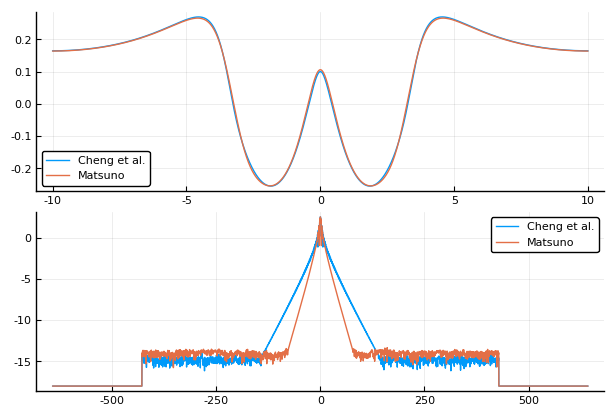

In [7]:
epsilon = 1/2
N       = 2^12
L       = 10
T       = 5
dt      = 0.001

@show epsilon,N,L,T,dt

mesh  = Mesh(-L, L, N)
times = Times(dt, T)

models = []
push!(models, Cheng(mesh, epsilon))
push!(models, Matsuno(mesh, epsilon))
    
@time run_simulations(mesh, models, times)
fig(5, times, models, mesh)